# Pruning in Deep Neural Networks

<div><img src="Images/horizontal_dark_logo.png" width = 300px style="padding:10px;"/>

<b>Authors</b>: Yanis Chaigneau, Nicolas Tirel

<b> Institution </b>: GreenAI UPPA
</div>



This notebook spans the state-of-the-art pruning methods in deep neural networks. Pruning is used to remove weights in a neural network, in order to reduce the number of parameters, leading to a faster training without loss in accuracy. Furthermore, it can be used to reduce the energetic consumption of ML algorithms. Indeed, the growing number of parameters in deep learning networks has an impact on the CO2 emissions of the sector, which these methods aim to reduce.

In the introduction,the historic of the field is drawn, with the presentation of the skeletonization (Mozer et al, 1989) and the Optimal Brain Damage (Lecun, 1990) pruning methods. A focus is then made on the pruning methods at initialization, with a comparison of three state-of-the-art algorithms: SNIP, GRASP and FORCE.

Pruning:

- Cut connexions in deep neural networks
- Reducing the size of a network
- Less energy consumption

I) Introduction and historics
II) Pruning at initialization: SNIP, GRaSP and FORCE
III) Comparison

# Introduction 

Different methods exist to prune a model. 
 - Pruning trained models
 - Induce sparsity during training
 - Pruning at initialization 
 
 
 <center><img src="images/sparsity.png" width=800px /></center>


Evolution of the number of publications containing "pruning" in the artificial intelligence field. Source: dimensions.ai


<center><img src="Images/pruning_citations.png" /></center>

## Pruning after training

Mozer and Smolensky in 1989: trimming the fat from a network via relevance assessment

  <center><img src="images/structure_pruning.png"/></center>


The method: <b>Skeletonization</b>

A method designed by Mozer and Smolensky in 1989 for trimming the fat from a network via relevance assessment. To do so, the <b>relevance</b> of each units is defined and computed, so as to reduce its size and improving its performance.

The procedure is the following:

#### Algorithm (Mozer et al)


    1) Train the network
    2) Compute the relevance of the units, so as to find which units have the more weight for the accuracy.
    3) Trim the least relevant units
    
This type of algorithms is useful for many reasons:
    - More generalization
    - Reduce the energy consumption by removing hidden units
    - Enhance interpretability

<b>First approach:</b> the relevance of a unit is determined by looking at the activity of each cells. The more the unit of the layer $l$ has many large-weighted connections, the more its activity should influence the other layers: $\rho_i = \sum_j w_{ij}$. However, if the effects of different connections cancel out, this is not a great metric. 

<b>Second approach: </b> The author defines the relevance of unit $i$ following the statement: <b>"what will happen to the performance of the network when a unit is removed ?"</b>

$$\rho_i = \mathcal{L}_{without~unit~i} - \mathcal{L}_{with~unit~i}$$ where $\mathcal{L}$ is the training loss.


<div class="alert alert-warning"><b>Question</b><br>
What is the complexity of computing $\rho$ for all the units if we want to try all the patterns $p$ with $n$ units?
</div>

<div class="alert alert-danger"><a href="#answer1" data-toggle="collapse"><b>Ready to see the answer? (click to expand)</b></a><br>
<div id="answer1" class="collapse">

$$\mathcal{O}(n p)$$ where $n$ is the total number of units in the network and $p$ the number of patterns in the training set.
</div>
</div>


The complexity is too large, we need to approximate the computation of $\rho$. To do so, we define $\alpha_i$ as the <b>attentional strength</b> of the unit, based on the attention mechanism. The idea of this coefficient is to represent whether a unit has an influence on the rest of the network. It simply weights the activation of a neuron j:

$$y_j = f(\sum_i w_{ij} \alpha_i x_{ij})$$

where $x_{ij}$ is the input from neuron $i$ to this neuron, $f$ the activation function, and $w_{ij}$ the input weights. Thus:

- if $\alpha_i = 0$, unit $i$ does not have any influence on the rest of the network
- if $\alpha_i = 1$, unit $i$ is a conventional unit.



The following figure depicts the attentional strength coefficients on a simple feed-forward neural network:

<center><img src="images/attentional_strength.png" /></center>


We then obtain a new definition for $\rho$:

$$\rho_i = \mathcal{L}_{\alpha_i = 0} - \mathcal{L}_{\alpha_i = 1}$$

With this definition, we can approximate the relevance of the units. To do so, let's use the derivative of the error with respect to $\alpha$:

$$\frac{\partial{\mathcal{L}}}{\partial \alpha_i} \Bigr|_{\substack{\alpha_i = 1}}= \lim_{\gamma \rightarrow 1} \frac{\mathcal{L}_{\alpha_i = \gamma} - \mathcal{L}_{\alpha_i = 1}}{\gamma - 1}$$

The approximation is made assuming it holds approximately for $\gamma = 0$:

$$\frac{\partial{\mathcal{L}}}{\partial \alpha_i} \Bigr|_{\substack{\alpha_i = 1}}= \frac{\mathcal{L}_{\alpha_i = 0} - \mathcal{L}_{\alpha_i = 1}}{- 1} = - \rho_i$$

Thus, we define $$\boxed{\hat{\rho}_i = - \frac{\partial{\mathcal{L}}}{\partial \alpha_i}} $$ with $\alpha_i$ supposed to be constant to $1$ and thus not being part of the trainable parameters of the systems.

Empirically, the authors defines the estimator of the relevance with the weighted average:

$$\boxed{\hat \rho_i (t+1) = 0.8 \hat \rho_i (t) + 0.2 \frac{\partial \mathcal{L} (t)}{\partial \alpha_i}}$$

The relevancy parameters can then be learned in a similar way as backpropagation.

The loss used to compute the relevancy parameters is the linear loss:

$$\mathcal{L} = \sum |\hat{y} - y|$$

<div class="alert alert-warning"><b>Question</b><br>
Does you see why the quadratic loss is not a good choice ?
</div>

<div class="alert alert-danger"><a href="#answer2" data-toggle="collapse"><b>Ready to see the answer? (click to expand)</b></a><br>
<div id="answer2" class="collapse">
    

Because the derivative of the loss goes to zero as the total error decreases, which will make the relevance of all the units tend to zero as the error decreases.
   
Then, it grossly underestimates the relevance of the outputs that are close to the target!.
    
</div>
</div>

### The algorithm

<div style="background-color:rgba(0, 0, 0, 0.0470588); padding:10px 0;font-family:monospace;">
For $t \in [0, \dots, T]$: <br />
&nbsp;&nbsp;&nbsp;&nbsp;Train the network until all output unit activities are within some specified margin around the target value <br />
&nbsp;&nbsp;&nbsp;&nbsp;Compute $\hat \rho_i$ for each unit $i$; <br />
&nbsp;&nbsp;&nbsp;&nbsp;Remove the unit with the smallest relevance

</div>

In python, a possible implementation can be the following (taken from Sébastien Lousteau)

In [ ]:
import torch

def forward(model,alpha, x):
        x = model.activations[0](model.conv1(x))
        x = x.view(-1, model.nb_filters * 8 * 8)
        x = [torch.mul(elt,alpha) for elt in x]
        x = torch.stack(x)
        x = model.fc1(x)
        return x

In [ ]:
def relevance(model,test_dataloader):
    autograd_tensor = torch.ones((model.nb_filters * 8 * 8), requires_grad=True)
    loss_fn = torch.nn.CrossEntropyLoss()
    num_items_read = 0
    device = next(model.parameters()).device
    gg = []
    lengths = []
    for _, (X, y) in enumerate(test_dataloader):
        if 100000 <= num_items_read:
            break
        X = X[:min(100000 - num_items_read, X.shape[0])]
        y = y[:min(100000 - num_items_read, X.shape[0])]
        num_items_read = min(100000, num_items_read + X.shape[0])
        X = X.to(device)
        y = y.to(device)
        pred = forward(model,autograd_tensor,X)
        loss = loss_fn(pred, y)
        gg.append(torch.autograd.grad(loss, autograd_tensor, retain_graph=True))
        lengths.append(X.shape[0])
    tensor_gg = torch.tensor([list(gg[k][0]) for k in range(len(gg))])
    result = torch.mean(tensor_gg,0)
    return(-result)

In [ ]:
def skeletonization(model,size,dataloader):
    relevance_ = relevance(model,dataloader)
    keep_indices = np.argsort(-np.array(relevance_))[:size]
    skeletone = ConvNet(model.nb_filters,model.channels)
    skeletone.conv1.weight.data = copy.deepcopy(model.conv1.weight.data)
    skeletone.fc1.weight.data = copy.deepcopy(model.fc1.weight.data)
    for index in set(range(4096))-set(keep_indices):
        skeletone.fc1.weight.data[:,index] = torch.zeros(10)
    return(skeletone)

### An example

Let's consider the following example taken from the official paper of Mozer and Smolensky:

<img src="images/example_mozer.png" width=200px></img>

In [1]:
## Generate the problem data
import random
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

N = 500
X = []
y = []

for i in range(N):
    A = random.randint(0, 1)
    B = random.randint(0, 1)
    C = random.randint(0, 1)
    D = random.randint(0, 1)
    
    X.append([A, B, C, D])
    
    if (A and B) or (not(A) and not(B) and not(C) and not(D)):
        y.append(1)
    else:
        y.append(-1)

X = np.array(X)
y = np.array(y)

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2)

## Optimal Brain Damage 

Optimal Brain Damage (OBD) has been developed in 1990 by Le Cun et al and is also used to reduce the size of a learning network by deleting weights. It consists in a trade off between the training error and the network complexity.

This technique uses the second derivative of the objective function to compute the "saliency" of the parameters. Here, saliency is not equal to the magnitude of the weights, and a theoretical framework is developed. 


The saliency of a parameter in this method is computed accordingly to the objective function which changes with the deletion of the parameters. The pruning is considered as a perturbation on the weight matrix. For that, we consider a perturbation of the parameter vector $\delta U$. This perturbation will affect the loss as:

$$\delta \mathcal{L} = \sum \limits_i g_i \delta u_i + \frac{1}{2} \sum \limits_i h_{ii} \delta u_i^2 + \frac{1}{2} \sum \limits_{i \not j} h_{ij} \delta u_i \delta u_j + \mathcal(O)(||\delta U||^3)$$

where $\delta u_i$ are the components of $\delta U$, $g_i$ the components of $\frac{\partial \mathcal{L}}{\partial U}$ and $h_i$ the components of the hessian matrix $h_{ij} = \frac{\partial^2 \mathcal{L}}{\partial u_i \partial u_j}$

After some assumptions, we reduce the equation to:

$$\delta \mathcal{L} = \frac{1}{2} \sum \limits_i h_{ii} \delta u_i^2$$


The second derivatives are then calculated with a backpropagation procedure.


#### The Algorithm

<div style="background-color:rgba(0, 0, 0, 0.0470588); padding:10px 0;font-family:monospace;">
For $t \in [0, \dots, T]$: <br />
&nbsp;&nbsp;&nbsp;&nbsp;Train the network until convergence <br />
&nbsp;&nbsp;&nbsp;&nbsp;Compute the second derivatives for each parameters $h_{kk}$ <br />
&nbsp;&nbsp;&nbsp;&nbsp;Compute the saliencies for each parameter $s_k = h_{kk} u_k^2/2$ <br />
&nbsp;&nbsp;&nbsp;&nbsp;Delete the lowest saliency parameters
</div>

Implementation: https://github.com/shekkizh/TensorflowProjects/blob/master/Model_Pruning/OptimalBrainDamage.py

## Sparsify during training

Example:  A BACK-PROPAGATION ALGORITHM WITH OPTIMAL USE OF HIDDEN UNITS (Chauvin, 1988)

<center><img src="Images/Chauvin.png" width=600px/></center>

## Pruning at initialization

Another class of pruning algorithms prune at initialization.


<center><img src="Images/pruning_initialization.png" /></center>

The three main algorithms that will be presented here are:
- SNIP
- GRASP
- FORCE

This kind of algorithms can be seen as a form of Neural Architecture Search.


# SNIP : SINGLE-SHOT NETWORK PRUNING BASED ON CONNECTION SENSITIVITY

##  The idea

Prune a neural network with the solution provided by Namhoon Lee et al. (2019) aimed the same purpose as the orginal paper from Mozer & Smolensky (1989). Indeed, the big advantages of a pruned network is a network simpler, more versatile and more interpretable. At the end, they achieve a good results with a pruned network with the same accuracy as existing baselines across all tested architectures.

## The maths behind

From a dataset $\mathcal{D} = {(x_i,y_i)}^n_{i=1}$ and a desired sparsity level $\mathcal{K}$ (the number of non-zero weights), we write the network pruning as the constrained optimization problem :
$$\min_wL(w;\mathcal{D}) = \min_w\frac{1}{n}\sum^n_{i=1}l(w;(x_i,y_i)),$$ $${s.t.~} w\in\mathbb{R}^m, ||w||_0 \leq \mathcal{K}.$$

l(.) -> standard loss function (e.g. cross-entropy)

w -> set of parameters of the NN

m-> total number of parameters

$||.||_0$ the standard $L_0$ norm


As we shown earlier, we can optimize this problem by adding sparsity enforcing penalty terms, but those solutions involve hyperparameter settings heavily tuned, and turn out to be inferior to saliency based methods.
The latter selectively remove redundant parameters with the magnitude of the weights (below certain threshold and redundant) and Hessian of the loss with respect to the weights  (high value of Hessian means high importance for the parameter)
$$ 
    s_j =\left\{
                \begin{array}{ll}
                  |w_j|, \text{ for magnitude based},\\
                  \frac{w_j^2 H_{jj}}{2}, \text{ for Hessian based.}
                \end{array}
              \right.
   $$

We have for connection j:

$s_j$ the saliency score

$w_j$ the weight

$H_{jj}$ the value of the Hessian matrix where the Hessian $H = \frac{∂^2L}{∂w^2} \in \mathbb{R}^{m*m}$



The problem of optimization can be written as :

$$ \min_{c,w} L(c ⊙ w; \mathcal{D}) = \min_{c,w} \frac{1}{n} \sum^n_{i=1} l(c ⊙ w; (x_i, y_i)), $$
$$ {s.t.~} w\in \mathbb{R^m},~ c\in \{0,1\}^m,~ ||c||_0 \leq \mathcal{K}  $$

The main idea is to separate the weight of the connection (w) from whether the connection is present or not (c). The value of $c_j$ indactes if the connection is active (=1) or pruned (=0). Therefore we can measure the effect of connection on the loss when $c_j=1$ and $c_j=0$ keeping everything else constant. We measure the effect then with :

$$\Delta L_j(\text{w};\mathcal{D}) = L(1\odot \text{w};\mathcal{D}) - L((1-e_j)\odot \text{w}; \mathcal{D}),$$

where $e_j$ indicates the element j (zeros everywhere except at the index j) and 1 the vector of dimension m (positive is improving, negative the opposite).
Because c is binary, to compute each $\Delta L_j$ is expensive and requires $m+1$ forward passes over the dataset, so by relaxing the constraint, we can approximate $\Delta L_j$ by the derivate of $L$ with respect to $c_j$, denote $g_j(\text{w};\mathcal{D})$. We obtain the following effect :

$$ \Delta L_j(\text{w}; \mathcal{D}) ≈ g_j(\text{w};\mathcal{D}) = \frac{∂L(c \odot \text{w}; \mathcal{D})}{∂c_j}|_{c=1} = \lim_{δ→0} \frac{L(c\odot \text{w}; \mathcal{D}) - L((c-\delta e_j) \odot \text{w}; \mathcal{D})}{δ} |_{c=1}
$$

This formulation can be viewed as perturbing the weight $w_j$ by a multilplicative factor $δ$ and measuring the change in loss.

To this end, they take the magnitude of the derivatives $g_j$ as the saliency criterion, and define connection sensitivity as the normalized magnitude of the derivatives :
$$
s_j = \frac{|g_j(\text{w};\mathcal{D})|}{∑^m_{k=1}|g_j(\text{w};\mathcal{D})|}
$$
After the computing, only the top-K ocnnections are retained, where k denotes the desired number of non-zero weights :
$$
c_j = \mathbf{1}[s_j - s_k ≥ 0 ], ∀j∈\{1~...m\},
$$
where $s_k$ is the $k$-th largest element in the vector s and $1[.]$ is the indicator function (for precision, we can broke ties aribtrarily )

The criteria depend on the loss value before pruning, require pre-training and iterative optimization cycles for a minimal loss in performance (+ magnitude and Hessian method very sensitive to the architectural choices)

## Algorithm

From the loss function $L$, trianing dataset $D$, sparsity level $k$

Ensure that $||w*||_0≤k$

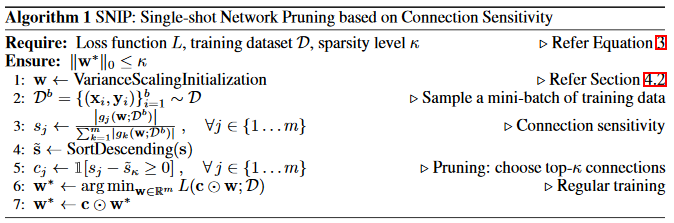

#### The Algorithm
    
    (1) Sample a mini-bacth of training data
    (2) compute saliency criterion (connection sensitivity) 
    (3) pruning: choose top-K connections
    (4) regular training

### Implementation in Python

#### Sample mini-batches

In [ ]:
def prune(args, model, sess, dataset):
    print('|========= START PRUNING =========|')
    # sample a mini-batch (by default 100)
    batch = dataset.get_next_batch('train', args.batch_size)
    feed_dict = {}
    feed_dict.update({model.inputs[key]: batch[key] for key in ['input', 'label']})
    feed_dict.update({model.compress: True, model.is_train: False, model.pruned: False})
    result = sess.run([model.outputs, model.sparsity], feed_dict)
    print('Pruning: {:.3f} global sparsity'.format(result[-1])

#### Pruning

In [ ]:
import tensorflow as tf
from model import Model
from dataset import Dataset

dataset = Dataset(**vars(args))
model = Model(num_classes=dataset.num_classes, **vars(args))
model.construct_model()
sess = tf.InteractiveSession()
tf.global_variables_initializer().run()
tf.local_variables_initializer().run()

# Prune
prune.prune(args, model, sess, dataset)

#### Sort the top k-values 

In [ ]:
# sort all the scores to obtains only the top-k% (by default top-10%)
def create_sparse_mask(mask, target_sparsity):
    def threshold_vec(vec, target_sparsity):
        num_params = vec.shape.as_list()[0]
        kappa = int(round(num_params * (1. - target_sparsity)))
        topk, ind = tf.nn.top_k(vec, k=kappa, sorted=True)
        mask_sparse_v = tf.sparse_to_dense(ind, tf.shape(vec),
            tf.ones_like(ind, dtype=tf.float32), validate_indices=False)
        return mask_sparse_v
    if isinstance(mask, dict):
        mask_v, restore_fn = vectorize_dict(mask)
        mask_sparse_v = threshold_vec(mask_v, target_sparsity)
        return restore_fn(mask_sparse_v)
    else:
        return threshold_vec(mask, target_sparsity)

#### Compute saliencies

In [ ]:
# In the construction of the model
def get_sparse_mask():
  w_mask = apply_mask(weights, mask_init)
  logits = net.forward_pass(w_mask, self.inputs['input'],
      self.is_train, trainable=False)
  loss = tf.reduce_mean(compute_loss(self.inputs['label'], logits))
  grads = tf.gradients(loss, [mask_init[k] for k in prn_keys])
  gradients = dict(zip(prn_keys, grads))
  # saliency score :
  cs = normalize_dict({k: tf.abs(v) for k, v in gradients.items()})
  return create_sparse_mask(cs, self.target_sparsity)

mask = tf.cond(self.compress, lambda: get_sparse_mask(), lambda: mask_prev)

Repo public tensorflow : https://github.com/namhoonlee/snip-public

Repo non officiel pytorch : https://github.com/mil-ad/snip

Article : https://arxiv.org/pdf/1810.02340.pdf

### Results

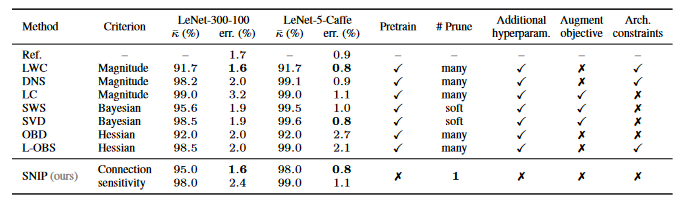

<div class="alert alert-warning"><a href="#answer3" data-toggle="collapse"><b>Hyper-parameters (click to expand)</b></a><br>
<div id="answer3" class="collapse">

Datasets : MNIST, CIFAR-10 and Tiny-ImageNet

They use the $\bar{k} = \frac{(m-k)}{m}.100(\%)$ $m$ the total number of parameters and $k$ the desired number of non-zero weights

The sensitivity scores are computed using a batch of 100 and 128 examples for MNIST and CIFAR

They train the models using SGD with momentum of .9, batch size of 100 and 128 and the weight decay rate of .0005 unless stated otherwise

Initial learning rate is .1, decayed by .1 at every 25k or 30k iterations 

90-10 training-validation
    
LeNet-300-100 consists of three fc layers with 267k parameters
LeNet-5-Caffe 2 fc with 431k param
    
</div>
</div>

https://arxiv.org/pdf/2002.07376.pdf

https://github.com/mil-ad/snip

Build on the same saliency criterion as in Mozer & Smolensky, but for training.

## GRASP (Gradient Signal Preservation)

Another method Gradient Signal Preservation (GraSP)

When H is approximated as the identity matrix, the above criterion recovers SNIP up to the absolute value
(recall the SNIP criterion is |δ>g|)

if S(δ) is negative, then removing the corresponding weights
will reduce the gradient flow, while if it is positive, it will increase the gradient flow.

For a given pruning ratio p, we obtain the resulting pruning mask by computing the score of every
weight, and removing the top p fraction of the weights (see Algorithm 1). Hence, GraSP takes the
gradient flow into account for pruning


https://github.com/alecwangcq/GraSP


$$\max_c G (\mathbf{\theta}, c) = \sum \limits_{i: c_i = 0} - \theta_i [\mathbf{H} \mathbf{g}]_i ~~ ,  c \in \{0,1\}^m, ~||c_0|| = k$$  

with $\mathbf{H} = \nabla^2 (\mathcal{L}(\theta_0))$ the Hessian Matrix of the loss and $\mathbf{g} = \nabla (\mathcal{L} (\theta_0))$ the gradient

## Force

In 2020, following the recent discoveries in the field of pruning, de Jorge et al published a paper describing a novel pruning algorithm: FORCE (foresight connection sensitivity).

In this work, we discovered that existing methods mostly perform below random pruning at
extreme sparsity regime

This algorithm applies the pruning before the training. Hence, not only the inference times drop, as the training times are also reduced.

It is based on the saliency criteria introduced by Mozer et Smolensky in (1989), skeletonization. The difference lies in the fact that the saliency that is optimized is the one lying after pruning, rather than before.


Let's recall the definition of the optimization process:

A sequence of iterates of parameters $\{\theta_i\}_{i=0}^{T}$ is produced during the training, with $\theta_0$ the initial set of parameters and $\theta_T$ the final one (leading to the minimal loss). In the classical pruning methods, one constraints the problem to reach a target sparsity level of $k<m$, to have $||\theta_T|| \leq k$.

When the pruning is done at initialisation, the goal is to find an initialization $\theta_0$ such that $||\theta_0|| \leq k$, the sequence following a specific topology during training.

We set $\mathbf{\bar{\theta}} = \mathbf{\theta} ⊙ \mathbf{c}$ where $\mathbf{c}$ is a binary mask (whether to remove the weight or not). We define the <b>connection sensitivity</b> $\mathbf{g}$ at $\mathbf{\bar{\theta}}$ for a given mask $\mathbf{\hat{c}}$ as:

$$\mathbf{g} (\mathbf{\bar{\theta}}) = \frac{\partial \mathcal{L} (\bar{\theta})}{\partial \mathbf{c}} \Bigr|_{\substack{\mathbf{c} = \mathbf{\hat{c}}}} = \frac{\partial \mathcal{L} (\bar{\theta})}{\partial \mathbf{\bar{\theta}}} \Bigr|_{\substack{\mathbf{c} = \mathbf{\hat{c}}}} ⊙ \frac{\partial \bar{\theta}}{\partial \mathbf{c}} \Bigr|_{\substack{\mathbf{c} = \mathbf{\hat{c}}}}
= \frac{\partial \mathcal{L} (\bar{\theta})}{\partial \mathbf{\bar{\theta}}} \Bigr|_{\substack{\mathbf{c} = \mathbf{\hat{c}}}} ⊙ \mathbf{\theta}$$

<div class="alert alert-warning"><b>Question</b><br>
What happens when $\hat{c} = 1$ ?
</div>

<div class="alert alert-danger"><a href="#answer4" data-toggle="collapse"><b>Ready to see the answer? (click to expand)</b></a><br>
<div id="answer4" class="collapse">
    
   
We retrieve the SNIP formulation !
    
"It assumes that all the parameters are active in the network and they are removed one by one with replacement, therefore, it fails to capture the impact of removing a group of parameters"
    
</div>
</div>

#### Differences with SNIP and GRaSP

- The formulation of the connection sensitivity depends directly on the pruned weights $\mathbf{\bar{\theta}}$, when GRaSP and SNIP depend on the weights only.

- In the case of extreme pruning ($||\mathbf{\hat{c}}||_0 << ||\mathbf{1}||_0$), we have $||\mathbf{\theta} ⊙ \mathbf{\hat{c}}||_2 << ||\mathbf{\theta}||_2$ giving highly different gradient values


#### Objective function

Find the best sub-network

$$ \max_c S(\mathbf{\theta}, \mathbf{c}) =  \sum \limits_{i \in supp(\mathbf{c})} | \theta_i \nabla \mathcal{L} (\mathbf{\theta} ⊙ \mathbf{c})_i | ~~ ,  c \in \{0,1\}^m, ~||c_0|| = k$$  

Finding the optimal solution requires to compute all the gradients of all the sub-networks. We have to approximate the solution --> Difference with SNIP

#### Progressive Pruning

The first solution is to use <b>progressive pruning</b> (also called iterative SNIP) with a homemade schedule $\{k_t\}_{t=1}^T,~k_T=k, ~k_t > k_{t+1}$ giving the pruning level:


$$c_{t+1} = \argmax_c S(\mathbf{\bar{\theta}}, \textbf{c}) ~~,c \in \{0,1\}^m, ~||c_0|| = k_{t+1}, \mathbf{c} ⊙ \mathbf{c_t} = \mathbf{c} $$ with $\mathbf{\bar{\theta}} = \theta ⊙ \mathbf{c}_t$

"The second constraint ensures that no parameter that had been pruned ealier is activated again". Indeed, let's consider this simple case:

$\mathbf{c} = \begin{pmatrix} 1 & 1 \\ 0 & 1 \end{pmatrix}$ and $\mathbf{c_t} = \begin{pmatrix} 0 & 0 \\ 0 & 1 \end{pmatrix}$. This case is not possible, as it would mean that three parameters would be reactivated.

The gradient approximation is then made: $\frac{\partial \mathcal{L} (\bar{\theta})}{\partial \bar{\theta}} \Bigr|_{\substack{\mathbf{c}_t}} \simeq \frac{\partial \mathcal{L} (\bar{\theta})}{\partial \bar{\theta}} \Bigr|_{\substack{\mathbf{c}_{t+1}}}$, which lies if the pruning schedule is smooth, ie $||\mathbf{c}_t||_0 \simeq ||\mathbf{c}_{t+1}||_0$


$\DeclareMathOperator*{\argmax}{arg\,max}$
#### Progressive sparsification (FORCE):

In this method, the constraint $\mathbf{c} ⊙ \mathbf{c}_t = \mathbf{c}$ is removed. It allows for parameters to resurrect, if they were removed at the beginning of the pruning. Thus, the weights are not removed but simply set to zero. They can have a non-zero gradient.

The network is pruned afterward.



#### Sparsity Schedule

We need to choose a schedule to iteratively prune the parameters, ie to choose a sequence $(k_t)_{t=1,\dots,T}$ with $k_T = k$ and $\forall t, ~k_t > k_{t+1}$. Futhermore, to respect the gradient approximation for the iterative SNIP case, the schedule needs to be smooth. The authors uses a simple exponential decay schedule:

$$\forall t,~k_t = \exp(\alpha \log k + (1- \alpha) \log m), \alpha = \frac{t}{T}$$




Text(0.5, 1.0, 'Numbers of parameters of the network given the iteration')

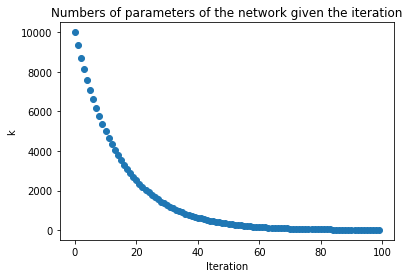

In [1]:
import numpy as np
import matplotlib.pyplot as plt

T = 100
k=10
m=10000

tv = list(range(T))
kt = [np.exp(t/T * np.log(k) + (1-t/T) * np.log(m))  for t in range(T)]

plt.scatter(tv, kt)
plt.xlabel('Iteration')
plt.ylabel('k')
plt.title('Numbers of parameters of the network given the iteration')


The resulting algorithm is the following:

<b>Inputs</b>: 
A training set $\mathcal{D}$, 
The desired sparsity level $k$, 
The number of steps (ie size of the sparsity schedule), 
The initial weights $\theta_0 \in \mathcal{R}^m$, 

<b> Compute the sparsity schedule (for instance the exponential decay) </b>

<b>Initialize</b> the initial mask , $\mathbf{c}_0 = \mathbf{1}$

<b>Repeat for</b> $t=0, \dots, T-1$:
- Sample mini-batch $\{z_i\}_{i=1}^n$ from the training set $\mathcal{D}$
- Define $\mathbf{\bar{\theta}} = \mathbf{\theta} ⊙ \mathbf{c}_t$
- Compute $\mathbf{g}(\mathbf{\bar{\theta}}) = \frac{\partial \mathcal{L} (\bar{\theta})}{\partial \bar{\theta}} \Bigr|_{\substack{\mathbf{c} = \mathbf{c}_t}} ⊙ \mathbf{\theta}$
- Get the top-$k_{t+1}$ values of $|\mathbf{g}_i| $ ie $I=\{i_1, \dots, i_{k_{t+1}}\}$
- Build $c_{t+1}$ setting to $0$ all indices not included in $I$


<b>Return</b> $c_T$





Mathematically, it can be shown that <b>each intermediate mask obtained with iterative SNIP is an approximate local minima </b> where the degree of sub-optimality increases with the pruning step size.

<div class="alert alert-warning"><a href="#answer3" data-toggle="collapse"><b>Demonstration of convergence</b></a><br>
<div id="answer3" class="collapse">

Datasets : MNIST, CIFAR-10 and Tiny-ImageNet

They use the $\bar{k} = \frac{(m-k)}{m}.100(\%)$ $m$ the total number of parameters and $k$ the desired number of non-zero weights

The sensitivity scores are computed using a batch of 100 and 128 examples for MNIST and CIFAR

They train the models using SGD with momentum of .9, batch size of 100 and 128 and the weight decay rate of .0005 unless stated otherwise

Initial learning rate is .1, decayed by .1 at every 25k or 30k iterations 

90-10 training-validation
    
LeNet-300-100 consists of three fc layers with 267k parameters
LeNet-5-Caffe 2 fc with 431k param
    
</div>
</div>

## Implementation

https://github.com/naver/force

# Results of the different pruning methods

Comparison on CIFAR10 and CIFAR100 datasets of two architectures (Resnet50 and VGG19)

#### Results on the training sets

<center><img src="images/results_force.png" /></center>


Very high pruning levels, removing layer collapse

#### Results on the test sets

<br />

<center><img src="images/results_force_2.png" /></center>



#### Results at different pruning levels

<img src="images/results_force_3.png" />



"no approach before has pruned a network at initialization to such extremes while keeping the network trainable"

Random pruning sometimes better

#### Computation times

<center><img src="images/force_time.png" width=600px/></center>


#### Evolution of the pruning with the two methods of FORCE (iterative SNIP and FORCE)

<center><img src="images/force_evolution_weights.png" /></center>

Force shows an exploration phase then a convergence phase during pruning (peak)

#### Weights Repartition

<center><img src="Images/weights_force.png" width=900px/></center>

## SynFlow

Layer-collapse (premature pruning of an entire layer making a network untrainable) for SNIP and GRASP ?

<center><img src="images/SynFlow_layer_collapse.png" width=600px/></center>


#### Interesting definitions and lemmas: 

<b>Compression ratio (ρ)</b>: the number of parameters in the original network divided by the number of parameters remaining after pruning. $\rho_{max} = \frac{N}{L}$

<b>Critical compression (ρcr)</b>:  is the maximal compression ratio a given algorithm can achieve without inducing layer-collapse.

<b>Lemma (Maximal Critical Compression)</b>: The critical compression of a pruning algorithm applied to a network should always equal the max compression of that network

In other words, this axiom implies a pruning algorithm should never prune a set of parameters that results in layer collapse if there exists another set of the same cardinality that will keep the network trainable.


# Application 

- Relation with: "How to learn sparse and binary CNNs"
    --> Apply these methods with MCMC
    
- For now, only magnitude pruning



## References 

[1] M. C. Mozer et P. Smolensky, « Skeletonization: A Technique for Trimming the Fat from a Network via Relevance Assessment », 1988.

[2]Y. LeCun, J. S. Denker, et S. A. Solla, « Optimal Brain Damage », 1989.


[3]N. Lee, T. Ajanthan, et P. H. S. Torr, « SNIP: Single-shot Network Pruning based on Connection Sensitivity », arXiv:1810.02340 [cs], févr. 2019, Consulté le: 21 janvier 2022. [En ligne]. Disponible sur: http://arxiv.org/abs/1810.02340


[4]C. Wang, G. Zhang, et R. Grosse, « Picking Winning Tickets Before Training by Preserving Gradient Flow », arXiv:2002.07376 [cs, stat], août 2020, Consulté le: janv. 03, 2022. [En ligne]. Disponible sur: http://arxiv.org/abs/2002.07376


[5]P. de Jorge, A. Sanyal, H. S. Behl, P. H. S. Torr, G. Rogez, et P. K. Dokania, « Progressive Skeletonization: Trimming more fat from a network at initialization », arXiv:2006.09081 [cs], mars 2021, Consulté le: janv. 03, 2022. [En ligne]. Disponible sur: http://arxiv.org/abs/2006.09081

[6]H. Tanaka, D. Kunin, D. L. K. Yamins, et S. Ganguli, « Pruning neural networks without any data by iteratively conserving synaptic flow », arXiv:2006.05467 [cond-mat, q-bio, stat], nov. 2020, Consulté le: janv. 10, 2022. [En ligne]. Disponible sur: http://arxiv.org/abs/2006.05467


## Implementations

GRASP:
https://github.com/alecwangcq/GraSP (official)

SNIP: 
https://github.com/namhoonlee/snip-public (official Tensorflow)
https://github.com/mil-ad/snip (official Pytorch)

FORCE: https://github.com/naver/force (official)



Pruning after training: https://github.com/jjgo/shrinkbench